# HoxHunt Summer Hunters 2021 - Data - Home assignment


<img src="http://hunters.hoxhunt.com/public/hero.svg" width="800">

## Assignment

In this assignment you as a HoxHunt Data Science Hunter are given the task to extract interesting features from a possible malicious indicator of compromise, more specifically in this case from a given potentially malicious URL. 

<img src="https://www.dropbox.com/s/ao0neaphtfama7g/Screenshot%202019-03-21%2017.23.40.png?dl=1" width="400">

This assignment assumes that you are comfortable (or quick to learn) on using Jupyter Notebooks and Python. You are free to use any external libraries you wish. We have included an example below using the Requests library.

Happy hunting!


## Interesting research papers & resources

Below is a list of interesting research papers on the topic. They might give you good tips what features you could extract from a given URL:


[Know Your Phish: Novel Techniques for Detecting
Phishing Sites and their Targets](https://arxiv.org/pdf/1510.06501.pdf)

[DeltaPhish: Detecting Phishing Webpages
in Compromised Websites](https://arxiv.org/pdf/1707.00317.pdf)

[PhishAri: Automatic Realtime Phishing Detection on Twitter](https://arxiv.org/pdf/1301.6899.pdf)

[More or Less? Predict the Social Influence of Malicious URLs on Social Media
](https://arxiv.org/abs/1812.02978)

[awesome-threat-intelligence](https://github.com/hslatman/awesome-threat-intelligence)



## What we expect

Investigate potential features you could extract from a given URL, and implement extractors for the ones that interest you the most. The example code below extracts one feature, but does not store it very efficiently (just console logs it). Implement a sensible data structure using some known data structure library to store the features per URL. Choose one feature for which you can visualise the results. What does the visualisation tell you? Also consider how you would approach error handling, if one of the feature extractor fails?

Should you make it to the next stage, be prepared to discuss the following topics: what features could indicate the malicousness of a given URL? What goes in to the thinking of the attacker when they are choosing a site for an attack? What inspired your solution and what would you develop next?

## What we don't expect

- That you implement a humangous set of features.
- That you implement any kind of actual predicition models that uses the features to give predictions on malicousness at this stage.

## Tips 


- Keep it tidy - a human is going to asses your work :)
- Ensure your program does not contain any unwanted behaviour
- What makes your solution stand out from the crowd?

-- Implementation begins here --

## Feature extraction

I decided to extract the following features from the URLs:

- Length of the url
- Length of the fully qualified domain name
- The number of subdomains

Additionally, I was interested in investigating the lengths of the redirection chains and the numbers of links pointing outside of the domain, as they were claimed to typically differ from a valid website.

After implementing these extractors, I collected some more test data from Phishtank and added them to a text file from which they can be conveniently read. However, due to the time constraints, the resulting dataset is still very small, merely 40 URLs.

After extracting the features from these URLs, the features are saved to a Pandas dataframe and also to a CSV file so that it's not necessary to extract these features every time this notebook is restarted.

In [1]:
import requests
import json
from urllib.parse import urlparse
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def get_domain_age_in_days(domain):
    show = "https://input.payapi.io/v1/api/fraud/domain/age/" + domain.strip()
    data = requests.get(show).json()
    return data['result'] if 'result' in data else None


def parse_domain_from_url(url):
    t = urlparse(url).netloc
    splitted_domains = '.'.join(t.split('.')[-2:])


def calculate_fqdn_length(url):
    """
    Calculates the length of the fully qualified domain name
    """
    fqdn = urlparse(url).netloc
    return len(fqdn)


def calculate_url_length(url):
    return len(url)


def calculate_number_of_subdomains(url):
    """
    Calculates the number of levels in the fully qualified domain name
    e.g. believable.phishing.site.com contains two subdomains (believable and phishing)
    """
    fqdn = urlparse(url).netloc
    subdomains = fqdn.split('.')[:-2]
    
    # if the list contains 'www', ignore it
    if(len(subdomains) > 0 and subdomains[0] != 'www'):
        return len(subdomains)
    elif(len(subdomains) > 0 and subdomains[0] == 'www'):
        return len(subdomains) - 1
    else:
        return 0
        
def calculate_number_of_redirects(url):
    """
    Calculates how many times the responding server redirects the request.
    
    Phishing websites tend to use redirection.
    """
    try:
        resp = requests.get(url.strip())
        return len(resp.history)
    except:
        return None
    
    
def get_rdns_from_hrefs(response):
    """
    Helper function to parse the links from the website
    """
    soup = BeautifulSoup(response, "lxml")

    rdns_found = []
    for link in soup.findAll('a'):
        url = link.get('href')
        try:
            urlparse(url)
            rdn = parse_domain_from_url(url)
            if(len(rdn) > 0):
                rdns_found.append(rdn)
        except:
            # in case of invalid url, don't do anything
            continue
    
    return rdns_found
    
    
def calculate_number_of_outgoing_hrefs(url):
    """
    extracts the hrefs from the phishing websites, compares its registered
    domain name (RDN) to the RDN of the url that we ended up in
    and calculates how many links does the site contain which point outside
    of the domain.
    
    Phishing websites tend to contain more external links.
    """
    try:
        req = Request(url.strip())
        resp = urlopen(req)
        final_url = resp.url
        final_rdn = parse_domain_from_url(final_url)
        href_rdns = get_rdns_from_hrefs(resp)
        
        n_of_external_rdns = 0
        for href_rdn in href_rdns:
            if(final_rdn != href_rdn):
                n_of_external_rdns += 1
        
        return n_of_external_rdns
        
    except:
        return None
    

def analyze_url(url):
    # First feature, if domain is new it could indicate that the bad guy has bought it recently...
    age_in_days_feature = get_domain_age_in_days(parse_domain_from_url(url));
    
    # Extract basic url features
    url_length = calculate_url_length(url)
    fqdn_length = calculate_fqdn_length(url)
    n_of_subdomains = calculate_number_of_subdomains(url)
    
    # Investigate more advanced features
    n_of_redirects = calculate_number_of_redirects(url)
    n_of_outgoing_hrefs = calculate_number_of_outgoing_hrefs(url)
    
    all_features = [age_in_days_feature, url_length, fqdn_length, n_of_subdomains, n_of_redirects, n_of_outgoing_hrefs]
    
    return all_features

In [4]:
def read_urls(filename):
    urls_file = open(filename, 'r')
    return urls_file.readlines()


def generate_feature_data(urls_to_analyze):
    data = []
    for url in urls_to_analyze:
        result = analyze_url(url)
        data.append(result)
    
    columns = ["age_in_days", "url_length", "fqdn_length", "n_of_subdomains", "n_of_redirects", "n_of_outgoing_hrefs"]
    
    return pd.DataFrame(data, columns=columns)

In [ ]:
urls_to_analyze = read_urls('phishing_urls.txt')
phishing_features_df = generate_feature_data(urls_to_analyze)

# save features so that they can be loaded later
phishing_features_df.to_csv("phishing_features.csv")

In [11]:
phishing_features_df = pd.read_csv('phishing_features.csv')

phishing_features_df.head()

,Unnamed: 0,age_in_days,url_length,fqdn_length,n_of_subdomains,n_of_redirects,n_of_outgoing_hrefs
0,0,5150.0,78,43,1,NaN,NaN
1,1,1152.0,27,11,0,2.0,NaN
2,2,NaN,61,24,0,0.0,1.0
3,3,4.0,50,24,1,NaN,NaN
4,4,2086.0,79,15,0,0.0,0.0


The data structure is shown in the table above. It can be observed that some of the phishing sites are not active anymore as the feature extractor is not able to find any redirects or links from the sites (NaN). I guess it's a good thing overall that many of these websites are not active anymore, but due to this inactivity, I was not really able to find out whether the length of redirect chains or outgoing links are abnormally high.

## Visualization

I decided to visualize the length of the fully qualified domain names (FQDN), as it was possible to calculate it for all the datapoints. In order to investigate if the length of the phishing FQDNs tend to be differ from valid FQDNs, top 40 valid urls were gathered from Alexa's collection of top sites on the web (https://www.alexa.com/topsites). The following code generates the same features for the valid urls and plots the phishing and valid FQDN's in a histogram:

In [ ]:
urls_to_analyze = read_urls('valid_urls.txt')
valid_features_df = generate_feature_data(urls_to_analyze)

# save features so that they can be loaded later
valid_features_df.to_csv('valid_features.csv')

In [10]:
valid_features_df = pd.read_csv("valid_features.csv")

valid_features_df.head()

,Unnamed: 0,age_in_days,url_length,fqdn_length,n_of_subdomains,n_of_redirects,n_of_outgoing_hrefs
0,0,8548.0,19,11,0,1.0,6.0
1,1,5838.0,20,12,0,1.0,2.0
2,2,NaN,18,10,0,1.0,11.0
3,3,7792.0,18,10,0,1.0,NaN
4,4,NaN,15,7,0,1.0,27.0


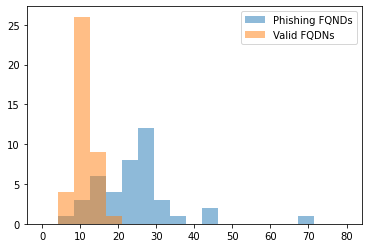

In [14]:
phishing_fqdn_lengths = phishing_features_df['fqdn_length']
valid_fqdn_lengths = valid_features_df['fqdn_length']

bins = np.linspace(0, 80, 20)

plt.hist(phishing_fqdn_lengths, bins, alpha=0.5, label='Phishing FQNDs')
plt.hist(valid_fqdn_lengths, bins, alpha=0.5, label='Valid FQDNs')
plt.legend(loc='upper right')
plt.show()

The histogram clearly shows that the lengths of the phishing FQDNs tend to be greater than the lengths of valid FQDNs. However, it is important to note that the valid urls utilized here are the most popular ones on the web meaning that the lengths of their FQDNs are naturally quite short. This means that this comparison is a bit biased, and in order to properly validate whether there's typically a difference in the lengths or not, significantly more data should be utilized in the comparison. This is omitted here due to time constraints.